<a href="https://colab.research.google.com/github/ElenaSelishcheva/ML_course_7_semester/blob/main/Homework_%E2%84%966.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Автокодировщик
Задачи: найти и загрузить в используемую библиотеку указанный набор данных, затем
обучить на нём сеть-автокодировщик и получить численную оценку качества восстановления
исходного изображения.

Loading the food dataset...
Loading the food dataset...
Net training...
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


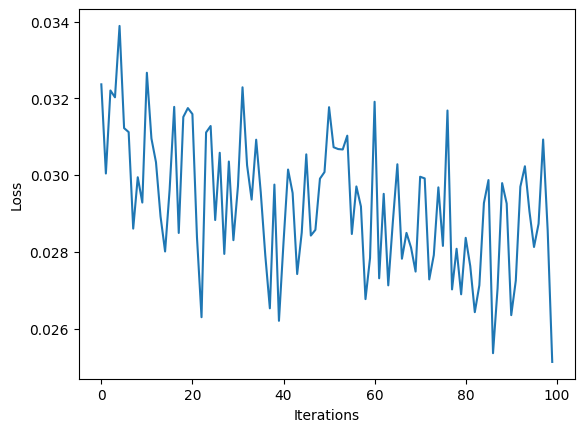

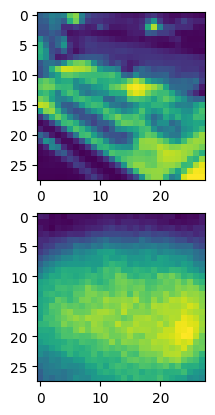

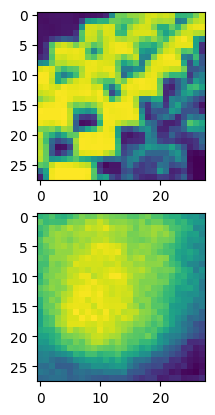

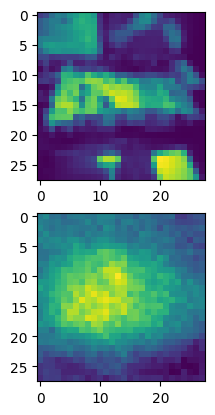

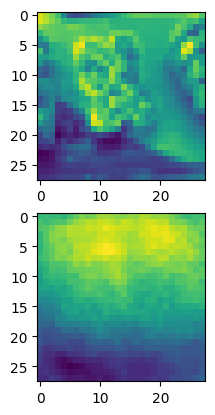

In [ ]:
# Мой датасет: Food101: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

# Моя архитектура: Число слоёв кодировщика и декодировщика — 2, размер закодированных данных — 30

import numpy as np
import matplotlib.pyplot as plt

from torch.nn import (Module, Sequential,
                      Linear, ReLU, Sigmoid,
                      MSELoss)
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import tarfile
import os
import requests
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets import Food101
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import Subset
import random



# класс автокодировщика
class Autoencoder(Module):
    def __init__(self):
        Module.__init__(self)
        layer1_num = 128
        layer2_num = 64

        # создаём сеть-кодировщик.
        self.encoder = Sequential(
            Linear(28 * 28, layer1_num),
            ReLU(),
            Linear(layer1_num, layer2_num),
            ReLU(),
            )

        # создаём сеть-декодировщик с аналогичными слоями,
        # расположенными в обратном порядке. Последний
        # слой позволяет ограничить диапазон выходов
        self.decoder = Sequential(
            ReLU(),
            Linear(layer2_num, layer1_num),
            ReLU(),
            Linear(layer1_num, 28*28),
            Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Гиперпараметры для обучения:
LR = 1e-3
WEIGHT_DECAY = 1e-8
BATCH_SIZE = 64
EPOCHS = 10

model = Autoencoder()

# качество будем оценивать с помощью MSE
loss_function = MSELoss()

optimizer = Adam(model.parameters(),
                 lr = LR,
                 weight_decay = WEIGHT_DECAY)

print("Loading the food dataset...")

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

CLASSES_TO_KEEP = ['pizza', 'sushi']

print("Loading the food dataset...")
trainData = datasets.Food101(root="data", split='train', download=True, transform=transform)
testData = datasets.Food101(root="data", split='test', download=True, transform=transform)

def filter_classes(dataset, classes_to_keep):
    indices = []
    for idx, (image, label) in enumerate(dataset):
        if dataset.classes[label] in classes_to_keep:
            indices.append(idx)
    return Subset(dataset, indices)

filtered_trainData = filter_classes(trainData, CLASSES_TO_KEEP)
filtered_testData = filter_classes(testData, CLASSES_TO_KEEP)

trainDataLoader = DataLoader(filtered_trainData, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = DataLoader(filtered_testData, batch_size=BATCH_SIZE)


losses = []
print("Net training...")
for epoch in range(EPOCHS):
    for (image, _) in trainDataLoader:

      # преобразуем данные из изображений (матриц) 28x28
      # в вектора длины 28*28
      image = image.reshape(-1, 28*28)

      # получаем закодированное и декодированное изображение
      # от автокодировщика
      reconstructed = model(image)

      # вычисляем функцию потерь
      loss = loss_function(reconstructed, image)

      # обнуляем градиент
      optimizer.zero_grad()
      # обсчитываем обратное распространение ошибки
      loss.backward()
      # обновляем параметры сети
      optimizer.step()

      # добавляем функцию ошибки в массив-лог
      losses.append(loss.item())
    print("Epoch {}/{}".format(epoch + 1, EPOCHS))


# график из 100 последних ошибок
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses[-100:])
plt.show()

# некоторые результаты восстановления на тестовой выборке
for i,(image, _) in enumerate(testDataLoader):
    reshaped_image = image.reshape(-1, 28*28)
    reconstructed = model(reshaped_image)
    img = reconstructed.reshape(-1, 28, 28)

    # выводим исходное и итоговое изображения
    f, axarr = plt.subplots(2,1)
    raw_image = image[0].detach().numpy()[0,:,:]
    rec_image = img[0].detach().numpy()
    axarr[0].imshow(raw_image)
    axarr[1].imshow(rec_image)
    plt.show(block=True)
    if i == 3: # выводим 3+1 первых изображений
        break
